In [1]:
import sys
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize
from scipy.special import softmax
import seaborn as sns
from sklearn import preprocessing
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import pickle
import hmm_main as h

Using cuDNN version 6021 on context None
Mapped name None to device cuda: GeForce GTX 1050 (0000:01:00.0)


In [2]:
import theano
import theano.tensor as T


In [3]:
#для отладки теано функций
def inspect_inputs(i, node, fn):
    print(i, node, "input(s) value(s):", [input[0] for input in fn.inputs],
          end='')

def inspect_outputs(i, node, fn):
    print(" output(s) value(s):", [output[0] for output in fn.outputs])


In [4]:
class HMM:
    def __init__(self, M, K):
        self.M = M # количество скрытых состояний
        self.K = K # число гауссиан
    
    def fit(self, X, learning_rate=1e-2, max_iter=10, keep=False):
       
        N = len(X)
        D = X[0].shape[1] # X[0].shape = (T, D)
        
        if not keep:
            pi0 = np.ones(self.M) 
            A0 = np.random.randn(self.M, self.M) 
            R0 = np.ones((self.M, self.K)) 
            mu0 = np.zeros((self.M, self.K, D))
            for i in range(self.M):
                for k in range(self.K):
                    random_idx = np.random.choice(N)
                    x = X[random_idx]
                    random_time_idx = np.random.choice(len(x))
                    mu0[i,k] = x[random_time_idx]
            sigma0 = np.random.randn(self.M, self.K, D, D)
            thx, cost = self.set(pi0, A0, R0, mu0, sigma0)
        else:
            thx, cost = self.set(self.preSoftmaxPi.get_value(), self.preSoftmaxA.get_value(), 
                                 self.preSoftmaxR.get_value(), self.mu.get_value(), self.sigmaFactor.get_value())

        pi_update = self.preSoftmaxPi - learning_rate*T.grad(cost, self.preSoftmaxPi)
        A_update = self.preSoftmaxA - learning_rate*T.grad(cost, self.preSoftmaxA)
        R_update = self.preSoftmaxR - learning_rate*T.grad(cost, self.preSoftmaxR)
        mu_update = self.mu - learning_rate*T.grad(cost, self.mu)
        sigma_update = self.sigmaFactor - learning_rate*T.grad(cost, self.sigmaFactor)

        updates = [
            (self.preSoftmaxPi, pi_update),
            (self.preSoftmaxA, A_update),
            (self.preSoftmaxR, R_update),
            (self.mu, mu_update),
            (self.sigmaFactor, sigma_update),
        ]

        train_op = theano.function(
            inputs=[thx],
            updates=updates,
        )

        costs = []
        for it in range(max_iter):
            print("it:", it)
            c = self.log_likelihood_multi(X).sum()
            print("c:", c)
            costs.append(c)            
            
            for n in range(N):
                train_op(X[n])

        plt.plot(costs)
        plt.show()

    def set(self, preSoftmaxPi, preSoftmaxA, preSoftmaxR, mu, sigmaFactor):
        self.preSoftmaxPi = theano.shared(preSoftmaxPi)
        self.preSoftmaxA = theano.shared(preSoftmaxA)
        self.preSoftmaxR = theano.shared(preSoftmaxR)
        self.mu = theano.shared(mu)
        self.sigmaFactor = theano.shared(sigmaFactor)
        M, K = preSoftmaxR.shape
        self.M = M
        self.K = K

        pi = T.nnet.softmax(self.preSoftmaxPi).flatten()
        A = T.nnet.softmax(self.preSoftmaxA)
        R = T.nnet.softmax(self.preSoftmaxR)


        D = self.mu.shape[2]
        twopiD = (2*np.pi)**D

        # настройка переменных и функций theano 
        thx = T.matrix('X') # матрица TxD последовательных наблюдений
        def mvn_pdf(x, m, S):
            k = 1 / T.sqrt(twopiD * T.nlinalg.det(S))
            e = T.exp(-0.5*(x - m).T.dot(T.nlinalg.matrix_inverse(S).dot(x - m)))
            return k*e

        def gmm_pdf(x):
            def state_pdfs(xt):
                def component_pdf(j, xt):
                    Bj_t = 0
                    for k in range(self.K):
                        L = self.sigmaFactor[j,k]
                        S = L.dot(L.T)
                        Bj_t += R[j,k] * mvn_pdf(xt, self.mu[j,k], S)
                    return Bj_t

                Bt, _ = theano.scan(
                    fn=component_pdf,
                    sequences=T.arange(self.M),
                    n_steps=self.M,
                    outputs_info=None,
                    non_sequences=[xt],
                )
                return Bt

            B, _ = theano.scan(
                fn=state_pdfs,
                sequences=x,
                n_steps=x.shape[0],
                outputs_info=None,
            )
            return B.T
        
        B = gmm_pdf(thx)
       
        def recurrence(t, old_a, B):
            a = old_a.dot(A) * B[:, t]
            s = a.sum()
            return (a / s), s

        [alpha, scale], _ = theano.scan(
            fn=recurrence,
            sequences=T.arange(1, thx.shape[0]),
            outputs_info=[pi*B[:,0], None],
            n_steps=thx.shape[0]-1,
            non_sequences=[B],
        )

        cost = -T.log(scale).sum()
        self.cost_op = theano.function(
            inputs=[thx],
            outputs=cost,
        )
        
        cost_detect = -T.log(scale)
        self.cost_detect = theano.function(
            inputs=[thx],
            outputs=cost_detect,
        )
        return thx, cost

    def log_likelihood_multi(self, X):
        return np.array([self.cost_op(x) for x in X])
    
    def log_likelihood_detect(self, X):
        return np.array(self.cost_detect(X))    

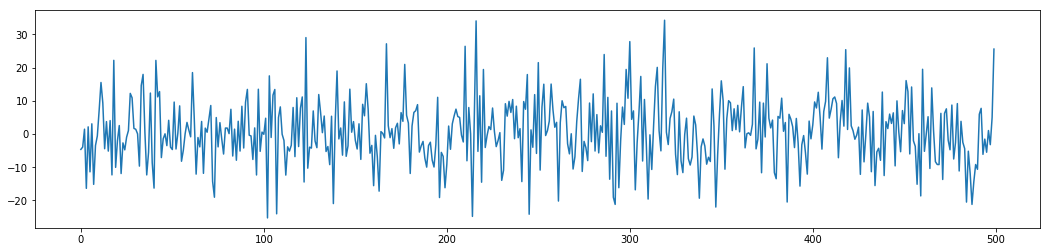

In [228]:
q = (10*np.random.randn(500) + 2*np.sin(np.linspace(0, 20*np.pi, 500)))
fig = plt.figure(figsize=(18, 4))
plt.plot(q)
plt.show()

In [7]:
def anom3_init(N,T):
    X = []
    for n in range(N):
        s = (10*np.random.randn(T) + 2*np.sin(np.linspace(0, 20*np.pi, T)))
        X.append(s.reshape(T,1))
    return X

def anom2_init(model= None):
    M = 1
    K = 1
    D = 1
    pi = np.array([1])
    A = np.array([[1]])
    R = np.array([[1]])
    mu = np.array([[[20]]])
    sigma = np.array([[[[0.0001]]]])
    return M, K, D, pi, A, R, mu, sigma

def anom1_init(model= None):
    M = 1
    K = 1
    D = 1
    pi = np.array([1])
    A = np.array([[1]])
    R = np.array([[1]])
    mu = np.array([[[10]]])
    sigma = np.array([[[[10]]]])
    return M, K, D, pi, A, R, mu, sigma

def anom0_init(model= None):
    M = 1
    K = 1
    D = 1
    pi = np.array([1])
    A = np.array([[1]])
    R = np.array([[1]])
    mu = np.array([[[-5]]])
    sigma = np.array([[[[1]]]])
    return M, K, D, pi, A, R, mu, sigma

def big_init(model= None):
    M = 5
    K = 3
    D = 1

    pi = np.array([1, 0, 0, 0, 0]) # initial state distribution

    A = np.array([
        [0.9, 0.025, 0.025, 0.025, 0.025],
        [0.025, 0.9, 0.025, 0.025, 0.025],
        [0.025, 0.025, 0.9, 0.025, 0.025],
        [0.025, 0.025, 0.025, 0.9, 0.025],
        [0.025, 0.025, 0.025, 0.025, 0.9],
    ]) # state transition matrix - likes to stay where it is

    R = np.ones((M, K)) / K # mixture proportions

    mu = np.array([
        [[0], [1], [2]],
        [[5], [6], [7]],
        [[10], [11], [12]],
        [[15], [16], [17]],
        [[20], [21], [22]],
    ]) # M x K x D

    sigma = np.zeros((M, K, D, D))
    for m in range(M):
        for k in range(K):
            sigma[m,k] = np.eye(D)
    return M, K, D, pi, A, R, mu, sigma

def hmm_init(model):
    
    mu = model.mu.get_value()
    sigmaFactor = model.sigmaFactor.get_value()
    
    pi = softmax(model.preSoftmaxPi.get_value())
    A = softmax(model.preSoftmaxA.get_value(), axis=1)
    R = softmax(model.preSoftmaxR.get_value(), axis=1)
    D = mu.shape[2]
    M, K = R.shape
    
    return M, K, D, pi, A, R, mu, sigmaFactor
    
def get_signals(N=20, T=100, init=big_init, hmm_model = None):
    if init == anom3_init:
        X = init(N,T)
    else:
        M, K, D, pi, A, R, mu, sigma = init(hmm_model)
        X = []
    
        def get_sigma_s_r(hmm_model, s, r, sigma):
            if hmm_model != None:
                L = sigma[s][r]
                return L.dot(L.T)
            else:
                return sigma[s,r]

        for n in range(N):
            x = np.zeros((T, D))
            s = np.random.choice(M, p = pi) # выбираем начальное состояние
            r = np.random.choice(K, p=R[s]) # choose mixture
            x[0] = np.random.multivariate_normal(mu[s][r], get_sigma_s_r(hmm_model, s, r, sigma))
            for t in range(1, T):
                s = np.random.choice(M, p=A[s]) # choose state
                r = np.random.choice(K, p=R[s]) # choose mixture
                x[t] = np.random.multivariate_normal(mu[s][r], get_sigma_s_r(hmm_model, s, r, sigma))
            X.append(x)
    return X

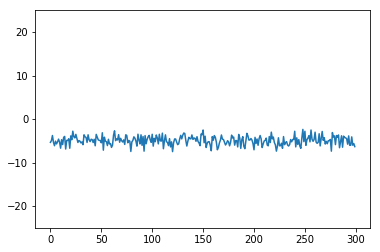

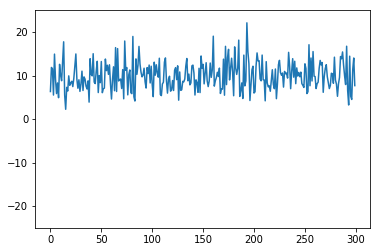

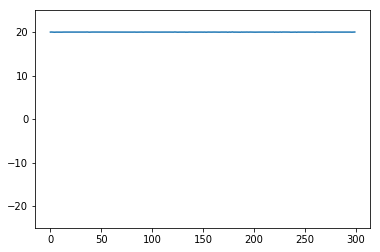

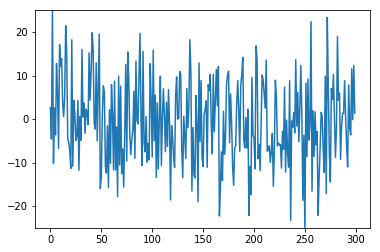

In [230]:
a1 = get_signals(N=1, T=300, init=anom0_init)[0]
a2 = get_signals(N=1, T=300, init=anom1_init)[0]
a3 = get_signals(N=1, T=300, init=anom2_init)[0]
a4 = get_signals(N=1, T=300, init=anom3_init)[0]
plt.plot(a1)
plt.ylim(-25, 25)
plt.show()
plt.plot(a2)
plt.ylim(-25, 25)
plt.show()
plt.plot(a3)
plt.ylim(-25, 25)
plt.show()
plt.plot(a4)
plt.ylim(-25, 25)
plt.show()

In [8]:
import pydot

it: 0
c: 246880.2682779754
it: 1
c: 139838.81247445766
it: 2
c: 139650.11561869917
it: 3
c: 139597.05387966393
it: 4
c: 139570.9977269687
it: 5
c: 139555.49633498862
it: 6
c: 139545.16964501457
it: 7
c: 139537.7480163391
it: 8
c: 139532.11054804618
it: 9
c: 139527.64134443202
it: 10
c: 139523.9740802149
it: 11
c: 139520.87701337866
it: 12
c: 139518.1958130207
it: 13
c: 139515.82058278337
it: 14
c: 139513.65939871076
it: 15
c: 139511.60349020822
it: 16
c: 139509.47008732488
it: 17
c: 139507.01755128338
it: 18
c: 139504.72009421338
it: 19
c: 139503.67190256208
it: 20
c: 139502.8028812066
it: 21
c: 139501.90183295193
it: 22
c: 139501.04202591514
it: 23
c: 139500.19751470536
it: 24
c: 139499.35502981988
it: 25
c: 139498.5030140345
it: 26
c: 139497.63210463012
it: 27
c: 139496.7361538794
it: 28
c: 139495.81407748946
it: 29
c: 139494.8708966527
it: 30
c: 139493.91515672763
it: 31
c: 139492.95268639643
it: 32
c: 139491.97753128616
it: 33
c: 139490.9593404599
it: 34
c: 139489.83286271084
it: 3

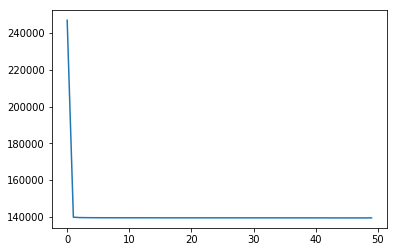

LL for fitted params: 139455.2329697017
LL for actual params: 127106.10754113557


In [24]:
signals = get_signals(N=200, T=300, init=big_init)
hmm = HMM(5, 3)
hmm.fit(signals, learning_rate=10e-3, max_iter=50)
L = hmm.log_likelihood_multi(signals).sum()
print('LL for fitted params:', L)

_, _, _, pi, A, R, mu, sigma = big_init()
# перевод в формы "pre-softmax" 
pi = np.log(pi)
A = np.log(A)
R = np.log(R)
# декомпозиция sigma с использованием факторизации 
sigma = np.linalg.cholesky(sigma)

hmm_real = HMM(5, 3)
hmm_real.set(pi, A, R, mu, sigma)
L = hmm_real.log_likelihood_multi(signals).sum()
print("LL for actual params:", L)

In [201]:
_, _, _, pi, A, R, mu, sigma = big_init()
#sigma = np.linalg.cholesky(sigma)
sigma[1,1]#.dot(sigma[1,1].T)

array([[1.]])

it: 0
c: 139455.2329697017
it: 1
c: 139454.94385383802
it: 2
c: 139454.7760527537
it: 3
c: 139454.69828049437
it: 4
c: 139454.6856616412
it: 5
c: 139454.7183050449
it: 6
c: 139454.78005958744
it: 7
c: 139454.85745550657
it: 8
c: 139454.93886331306
it: 9
c: 139455.01392076432
it: 10
c: 139455.07327501607
it: 11
c: 139455.10865260536
it: 12
c: 139455.1132007328
it: 13
c: 139455.08195095966
it: 14
c: 139455.01217592807
it: 15
c: 139454.90339482517
it: 16
c: 139454.75688013656
it: 17
c: 139454.57472393016
it: 18
c: 139454.35875622174
it: 19
c: 139454.10973266914


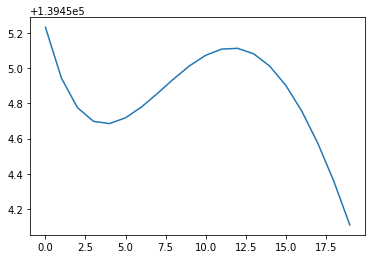

LL for fitted params: 139453.82711200003


In [26]:
hmm.fit(signals, learning_rate=10e-3, max_iter=20, keep=True)

L = hmm.log_likelihood_multi(signals).sum()
print('LL for fitted params:', L)


In [27]:
# ЗАПИСЬ!!!!!!
#with open('C:/Users/DNS/NIR/hmm_big_init.pkl', 'wb') as dump_out:
#      pickle.dump(hmm, dump_out)

In [234]:
# ЧТЕНИЕ
with open('C:/Users/DNS/NIR/hmm_big_init.pkl', 'rb') as dump_out:
      hmm = pickle.load(dump_out)

In [231]:
def mix_examples(N=10, T = 100, len_past = 10, anom_init = anom0_init, gap=20):
    signals = get_signals(N, T, init = big_init)
    anomalises = get_signals(N, len_past, init = anom_init)
    idx = np.random.choice(T-len_past-1, size = N, replace = False)
    label = np.zeros((N,T))
    for i in range(N):
        idx_an = min(idx[i], idx[i]-gap)
        #print(idx[i], idx_an)
        signals[i][idx[i]:idx[i]+len_past,0] = anomalises[i][:,0]
        label[i][idx_an:idx[i]+len_past]+=1
    return signals, label
    

In [232]:
def get_example(T = 100, k = 0.1, rate = 0.3, name_an = None ):
    
    if name_an== None:
        name_an = [anom0_init, anom1_init, anom3_init]
    
    l = int(T*(1-rate)//2)
    max_len = int(k*T)
    
    label = np.zeros((T))
    X = np.empty(shape=[0, 1])
    while X.shape[0] < T:
        
        limit = min(l ,T-X.shape[0])
        if limit > 10:
            X = np.concatenate([X, get_signals(1, np.random.randint(10,limit), init = big_init)[0]])
        
        init = np.random.choice(name_an)
        if init in [anom1_init, anom2_init]:
            min_len = 20
        else:
            min_len = 5
            
        limit = min(T-X.shape[0],max_len)
        
        if limit > min_len:
            len_past = np.random.randint(5,limit)
            X = np.concatenate([X, get_signals(1, len_past, init = np.random.choice(name_an))[0]])
            label[min(X.shape[0],T)-len_past: min(X.shape[0],T)] = 1
        else:
            X = np.concatenate([X, get_signals(1, limit, init = big_init)[0]])
               
        if X.shape[0] > T:
            X = np.delete(X, range(T,t), axis = 0)
            
                                 
    return X, label

def get_test_set(N=10, T=100, k=0.1, rate=0.3, name_an = None):
    X = []
    Y = []
    for n in range(N):
        x,y = get_example(T, k, rate, name_an)
        X.append(x)
        Y.append(y)
    return X, Y
    

In [87]:
X_anom2, Y_anom2 = get_test_set(N=10, T=1000, name_an = [anom2_init, anom2_init])

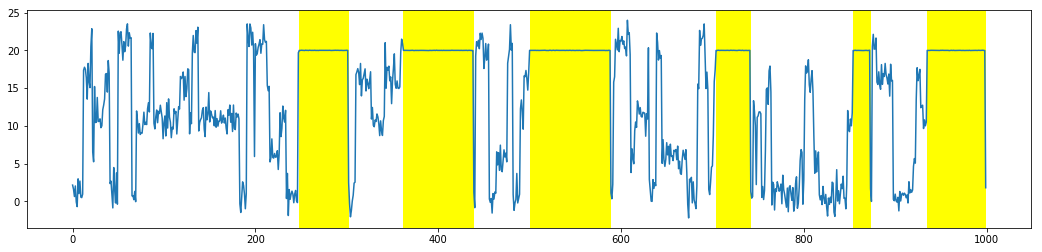

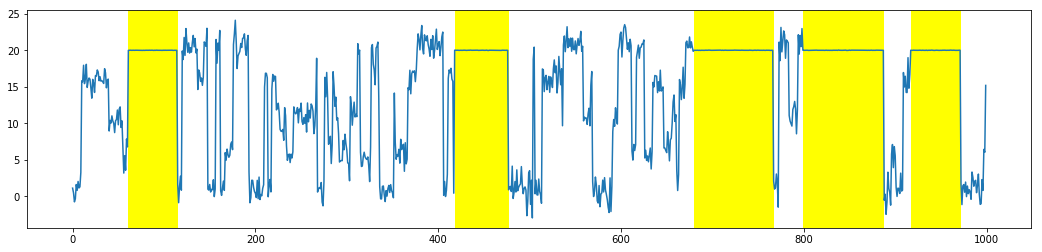

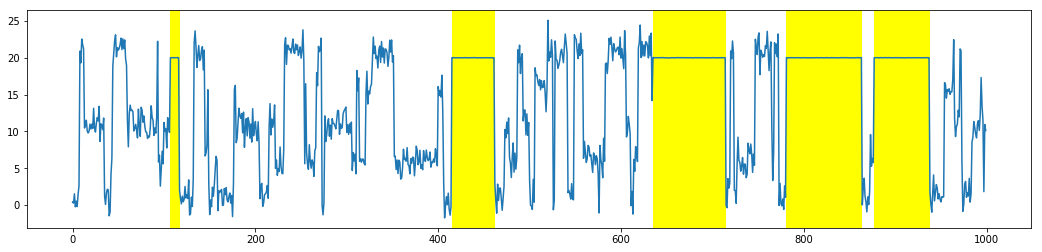

In [88]:
axis = range(X_anom2[0].shape[0])
plt.figure(figsize=(18, 4))
plt.plot(axis, X_anom2[0])

idxs = np.where(Y_anom2[0] == Y_anom2[0].max())[0]
for i in range(len(idxs)):
    plt.axvspan(idxs[i], idxs[i], color='yellow')
plt.show() 

axis = range(X_anom2[1].shape[0])
plt.figure(figsize=(18, 4))
plt.plot(axis, X_anom2[1])

idxs = np.where(Y_anom2[1] == Y_anom2[1].max())[0]
for i in range(len(idxs)):
    plt.axvspan(idxs[i], idxs[i], color='yellow')
plt.show()

axis = range(X_anom2[2].shape[0])
plt.figure(figsize=(18, 4))
plt.plot(axis, X_anom2[2])

idxs = np.where(Y_anom2[2] == Y_anom2[2].max())[0]
for i in range(len(idxs)):
    plt.axvspan(idxs[i], idxs[i], color='yellow')
plt.show()

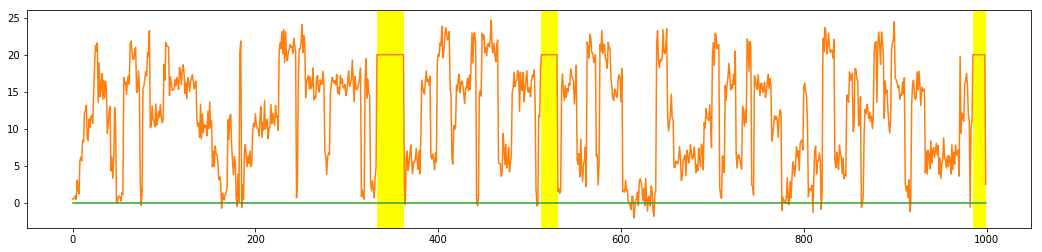

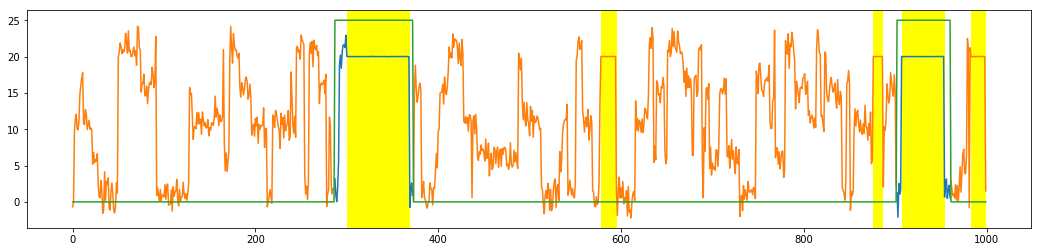

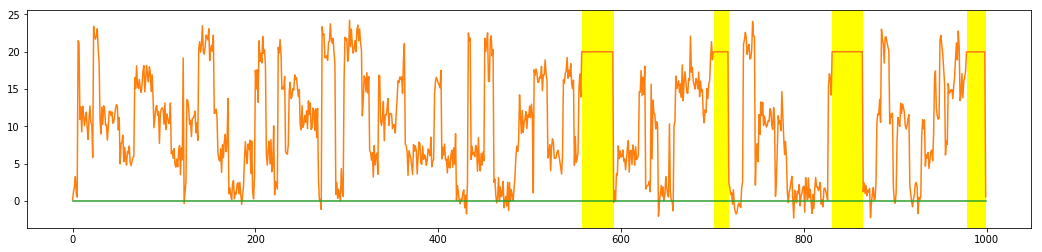

              precision    recall  f1-score   support

      normal       0.94      0.94      0.94      8707
      anomal       0.59      0.61      0.60      1293

    accuracy                           0.90     10000
   macro avg       0.77      0.77      0.77     10000
weighted avg       0.90      0.90      0.90     10000



In [24]:
ws = 45
eps = 0.25
sens = 0
Y_pred_anom2 = predict(hmm, X_anom2, Y_anom2, win_size= ws, eps = eps, sens =sens)
print_result(X_anom2, Y_anom2, Y_pred_anom2, N=3)
report_anom2 = classification_report(np.concatenate(Y_anom2), np.concatenate(Y_pred_anom2), target_names=['normal', 'anomal'])
print(report_anom2)

In [233]:
X_test, Y_test = get_test_set(N=100, T=1000, k=0.1, rate=0.4, name_an = [anom0_init, anom1_init, anom2_init, anom3_init])


In [192]:
#ЗАПИСЬ!!!!!!
for_save = (X_test, Y_test)
with open('C:/Users/DNS/NIR/X_Y_test.pkl', 'wb') as dump_out:
      pickle.dump(for_save, dump_out)
with open('C:/Users/DNS/NIR/X_train.pkl', 'wb') as dump_out:
      pickle.dump(get_signals(N=200, T=300, init=big_init), dump_out)        
       


In [ ]:
# ЧТЕНИЕ
with open('/content/X_train.pkl', 'rb') as dump_out:
      X_train = pickle.load(dump_out)

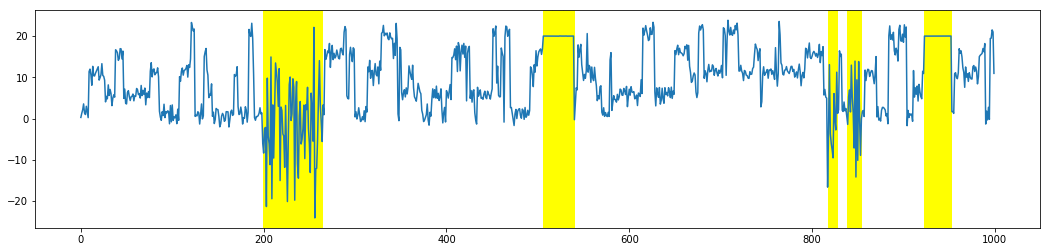

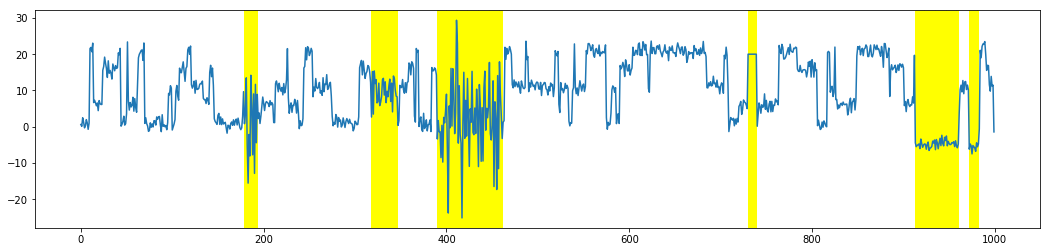

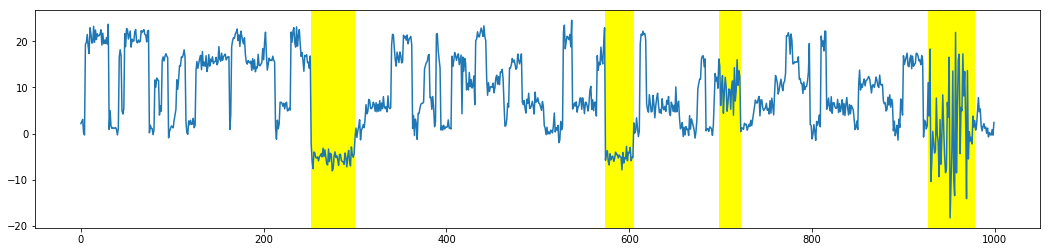

In [13]:
axis = range(X_test[0].shape[0])
plt.figure(figsize=(18, 4))
plt.plot(axis, X_test[7])

idxs = np.where(Y_test[7] == Y_test[7].max())[0]
for i in range(len(idxs)):
    plt.axvspan(idxs[i], idxs[i], color='yellow')
plt.show() 

axis = range(X_test[7].shape[0])
plt.figure(figsize=(18, 4))
plt.plot(axis, X_test[5])

idxs = np.where(Y_test[5] == Y_test[5].max())[0]
for i in range(len(idxs)):
    plt.axvspan(idxs[i], idxs[i], color='yellow')
plt.show()

axis = range(X_test[2].shape[0])
plt.figure(figsize=(18, 4))
plt.plot(axis, X_test[6])

idxs = np.where(Y_test[6] == Y_test[6].max())[0]
for i in range(len(idxs)):
    plt.axvspan(idxs[i], idxs[i], color='yellow')
plt.show()

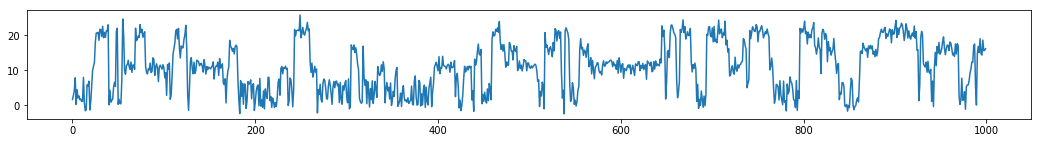

In [195]:
s_hmm = get_signals(N=1, T=1000, init = hmm_init, hmm_model = hmm)
axis = range(1000)
plt.figure(figsize=(18, 2))
plt.plot(axis, s_hmm[0][:]) 
plt.show()

In [68]:

def anomaly_detection(LL_std, hmm_model, signal, win_size= 100, eps = 0.25, step = 1):
    n_step = signal.shape[0]
    LL = hmm_model.log_likelihood_detect(signal)
    an = np.zeros(n_step)
    Y = np.zeros(n_step)
    t=0
    #for t in range(0,(n_step-win_size+step) , step):
    while t < (n_step-win_size+step):
        if t > (n_step-win_size):
            t = n_step-win_size
        MAPE = abs(LL[t:t+win_size].sum()-LL_std)/LL_std
        if MAPE > eps :
            #if t==0 or t+win_size == n_step:
           #     Y[t:t+win_size] =1
           # else:
                #Y[t:t+step] =1
            Y[t:t+win_size] =1
            t += win_size
        else:
            t += step 
            #LL[t] = LL_hmm[t]
    #Y[np.where(an>an.max()*sens)] = 1          
    return Y 

def predict(model, X, Y, win_size=50, eps=0.25, step =1):
    Y_pred = []
    hmm_signal = get_signals(100, win_size ,init=hmm_init, hmm_model = model)
    LL_std = np.array([model.log_likelihood_detect(x) for x in hmm_signal]).sum()/100
    for x in X:
        Y_pred.append(anomaly_detection(LL_std, model, x, win_size, eps, step))
        
    return Y_pred

def score(Y, Y_pred, ws = 50): 
    
    T = Y[0].shape[0]
    assert (T%ws==0), "неверный размер окна"
    Y_new = []
    Y_pred_new = []
    
    for i in range(len(Y)):
        a = Y[i].reshape(T//ws, ws)
        b = Y_pred[i].reshape(T//ws, ws)
        
        y_new = np.zeros((T//ws))
        y_pred_new = np.zeros((T//ws))
        
        for j in range(a.shape[0]):
            if np.where(a[j]==1)[0].shape[0] != 0:
                y_new[j] = 1
            if np.where(b[j]==1)[0].shape[0] != 0:
                y_pred_new[j] = 1
                
        Y_new.append(y_new)
        Y_pred_new.append(y_pred_new)
        
    return Y_new, Y_pred_new           
            

In [15]:
def print_result(X, Y, Y_pred, N=3):
    for n in range(N):
        norm = np.ma.masked_where(Y_pred[n]==0,X[n][:,0])
        anom = np.ma.masked_where(Y_pred[n]==1,X[n][:,0])
        fig = plt.figure(figsize=(18, 4))
        axis = range(Y_pred[n].shape[0])
        idxs = np.where(Y[n] == Y[n].max())[0]
        for i in idxs:
            plt.axvspan(i, i, color='yellow')
        plt.plot(axis, norm, axis, anom, axis, Y_pred[n]*25)
        plt.show()       
    

In [184]:
def testing(X, Y, model):
    ws = [20, 40, 60, 80, 100, 120]
    eps = [0.15, 0.20, 0.25, 0.3, 0.35, 0.4]
    step = [10, 20, 20, 20, 20, 20]
    
    

(1000,)

In [37]:
ws = 45
eps = 0.25
step = 20
Y_pred = predict(hmm, X_test, Y_test, win_size= ws, eps = eps, step = step)
Y_score, Y_pred_score = score(Y_test, Y_pred, ws = 50)    


In [106]:
report = classification_report(np.concatenate(Y_score), np.concatenate(Y_pred_score), target_names=['normal', 'anomal'])
print(report)

              precision    recall  f1-score   support

      normal       0.86      0.84      0.85      1067
      anomal       0.82      0.85      0.83       933

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



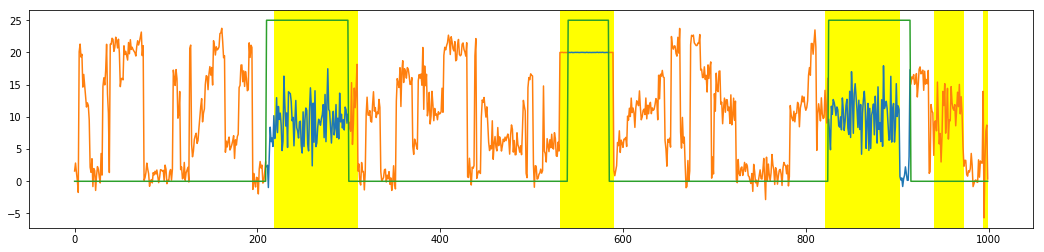

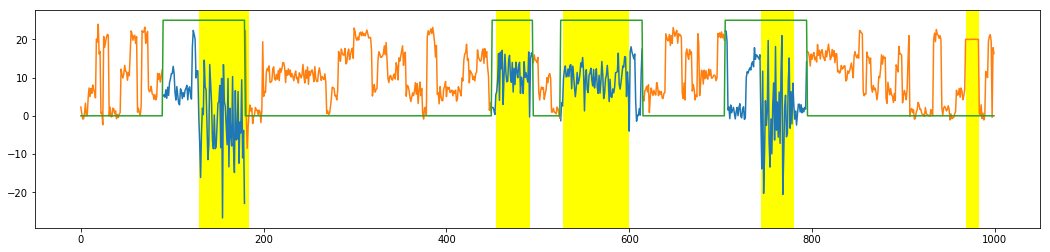

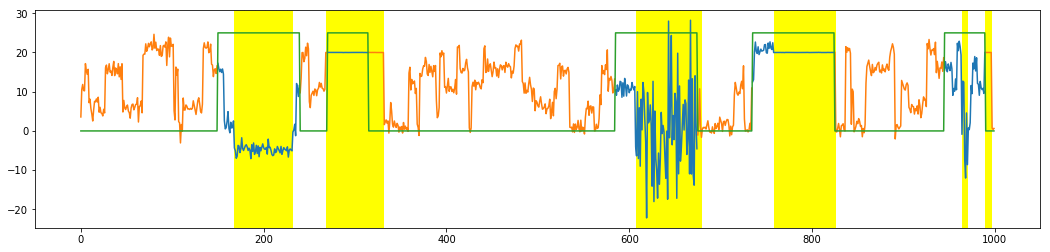

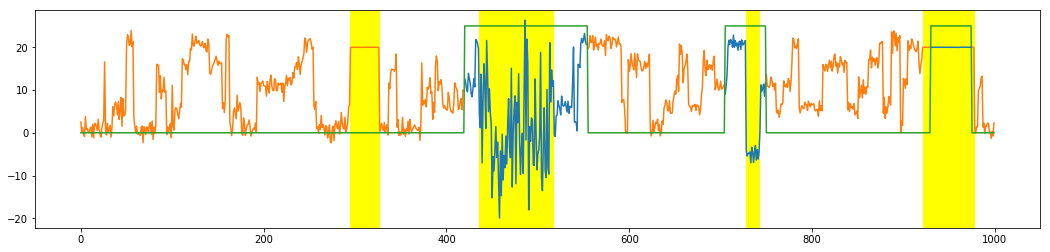

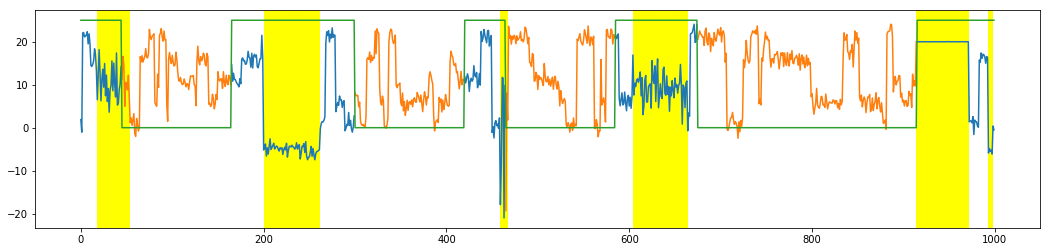

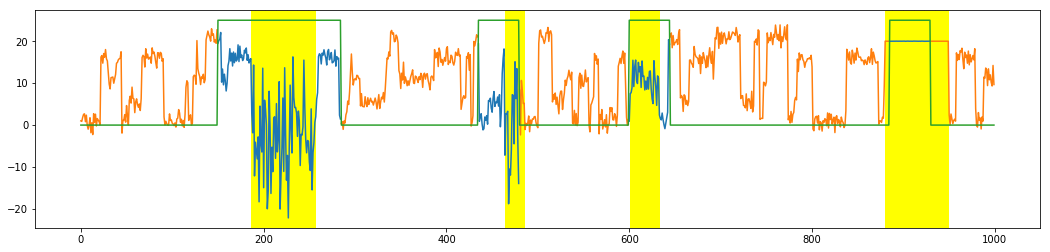

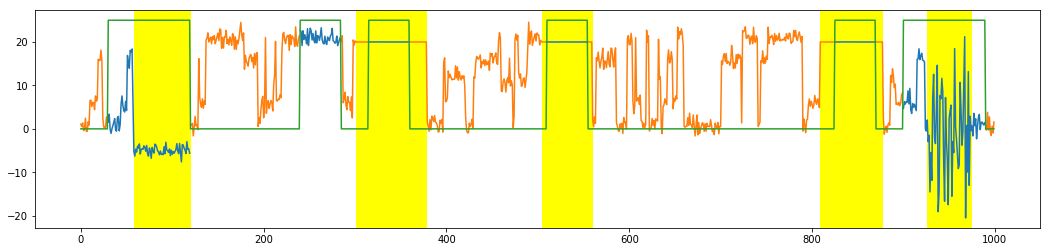

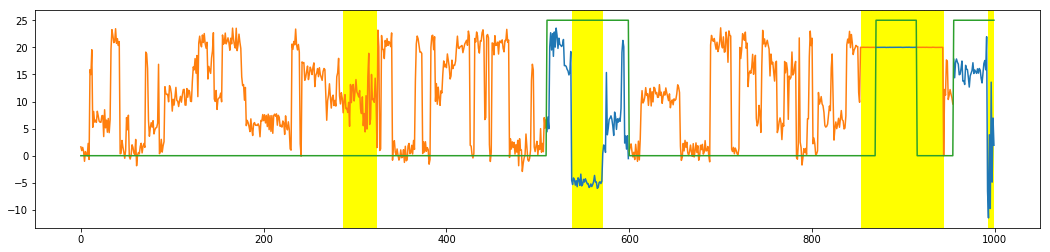

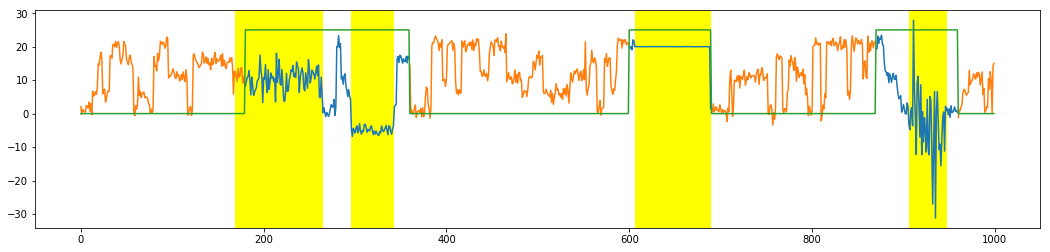

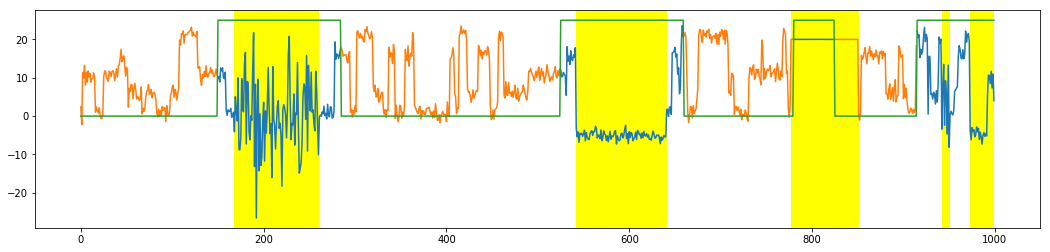

In [38]:
print_result(X_test[40:], Y_test[40:], Y_pred[40:], N=10)

In [70]:
# ЗАПИСЬ!!!!!!
with open('C:/Users/DNS/NIR/report_big_init_ws'+str(ws)+'eps'+str(eps)+'step'+str(step)+'.pkl', 'wb') as dump_out:
      pickle.dump(report, dump_out)

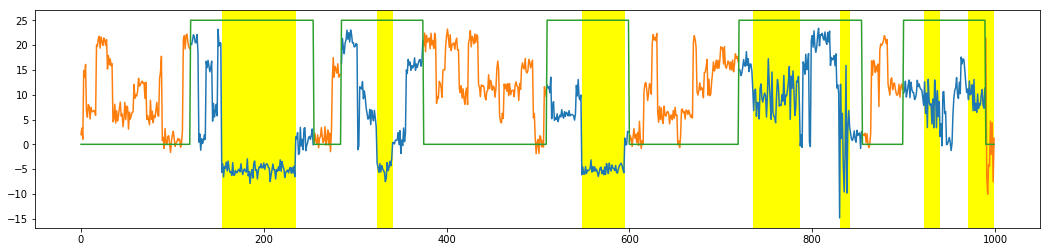

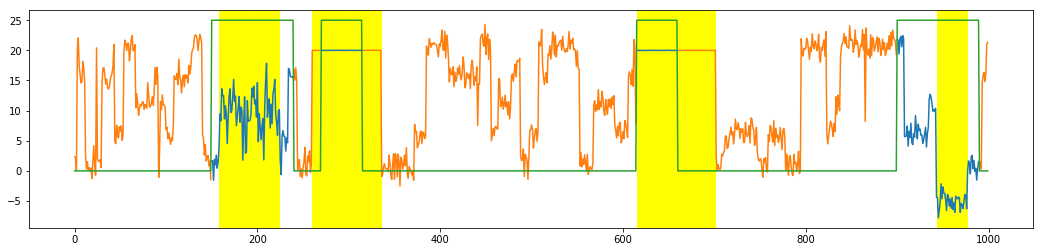

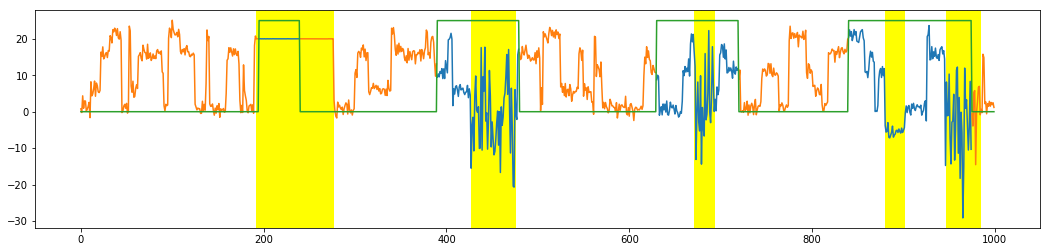

              precision    recall  f1-score   support

      normal       0.93      0.78      0.85     75522
      anomal       0.55      0.82      0.66     24478

    accuracy                           0.79    100000
   macro avg       0.74      0.80      0.75    100000
weighted avg       0.84      0.79      0.80    100000



In [40]:
_, _, _, pi, A, R, mu, sigma = big_init()
# перевод в формы "pre-softmax" 
pi = np.log(pi)
A = np.log(A)
R = np.log(R)
# декомпозиция sigma с использованием факторизации 
sigma = np.linalg.cholesky(sigma)

hmm_real = HMM(5, 3)
hmm_real.set(pi, A, R, mu, sigma)

ws = 45
eps = 0.25
step = 15
Y_pred_real = predict(hmm_real, X_test, Y_test, win_size= ws, eps = eps, step =step)
print_result(X_test, Y_test, Y_pred_real, N=3)
report_real = classification_report(np.concatenate(Y_test), np.concatenate(Y_pred_real), target_names=['normal', 'anomal'])
print(report_real)


In [76]:
with open('C:/Users/DNS/NIR/report_big_init_real__ws'+str(ws)+'eps'+str(eps)+'sens'+str(step)+'.pkl', 'wb') as dump_out:
      pickle.dump(report_real, dump_out)

In [ ]:
fig = plt.figure(figsize=(18, 4))
axis = range(n_step)
#cl = ['red' if x ==1 else 'darkgreen' for x in anomalises]
plt.plot(axis, norm_s0, axis, anom_s0, axis, anomalises[0]*25)
idxs = np.where(Y[0] == Y.max())[0]
plt.axvspan(idxs[0], idxs[-1], color='yellow')
plt.show()
fig = plt.figure(figsize=(18, 4))
axis = range(n_step)
#cl = ['red' if x ==1 else 'darkgreen' for x in anomalises]
plt.plot(axis, norm_s1, axis, anom_s1, axis, anomalises[1]*25)
idxs = np.where(Y[1] == Y.max())[0]
plt.axvspan(idxs[0], idxs[-1], color='yellow')
plt.show()

СРАВНЕНИЕ С ДРУГИМИ АЛГОРИТМАМИ

In [102]:
X1_train = np.concatenate([x.reshape(x.shape[0]) for x in get_signals(N=200, T=300, init=big_init)])

In [91]:
X1_test = np.concatenate([x.reshape(x.shape[0]) for x in X_test])

In [172]:
import ECDF
model=ECDF.DefaultDetector(window=20, alpha=0.01, threshold=0.1)
model.fit(X_train)
Y1_pred=model.detect(X1_test)


In [173]:
c =Y1_pred.reshape(len(Y_test),Y_test[0].shape[0])*1
#c[40:][5]

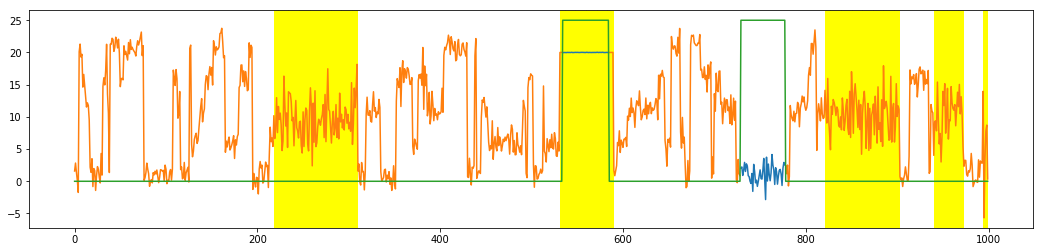

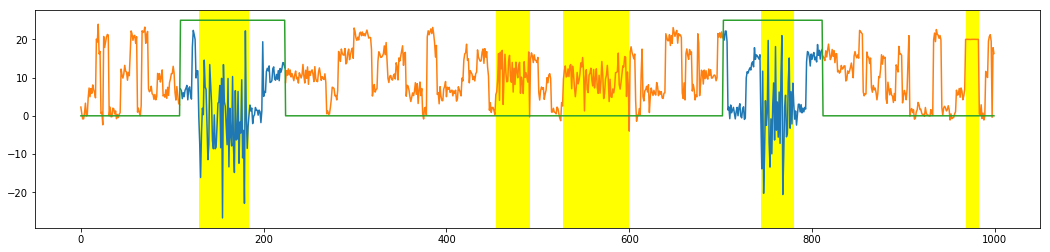

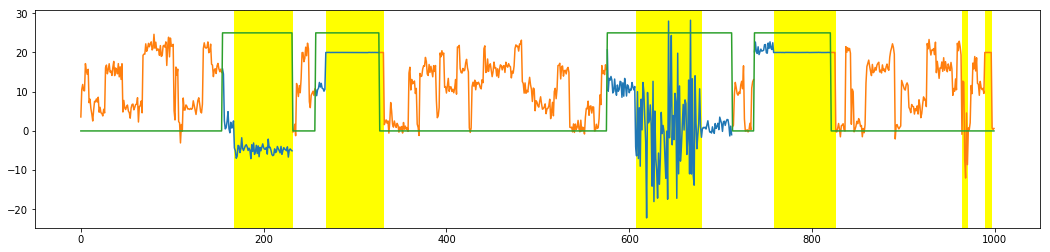

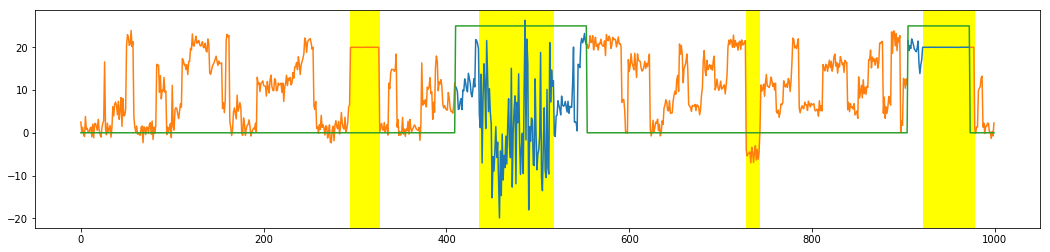

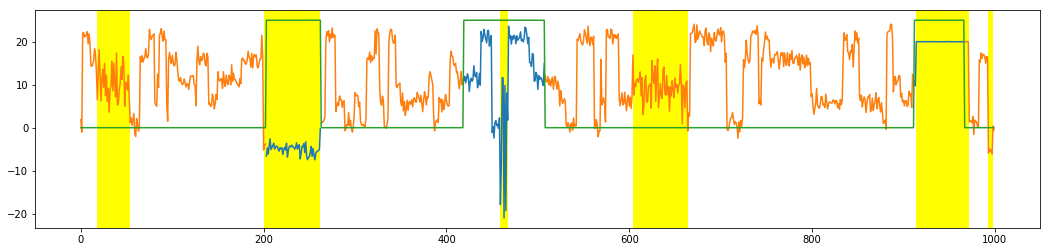

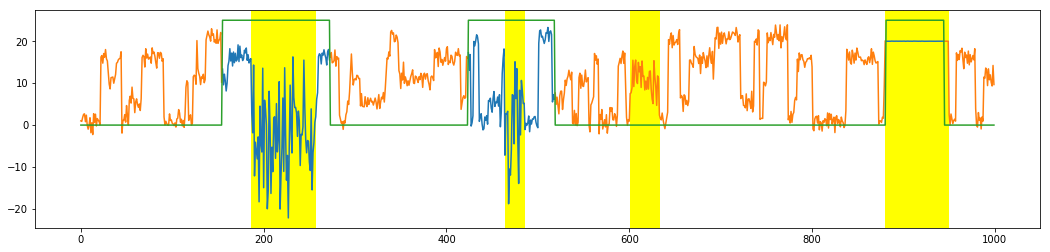

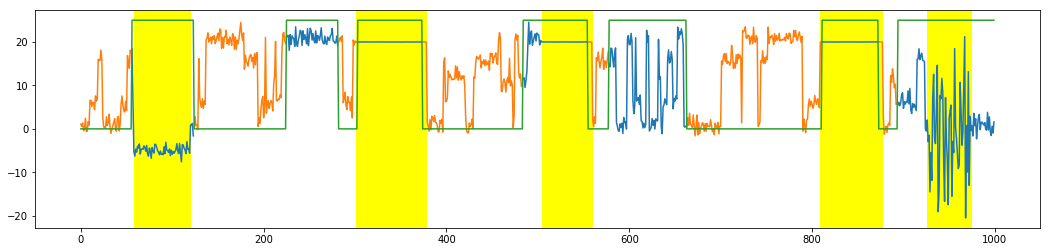

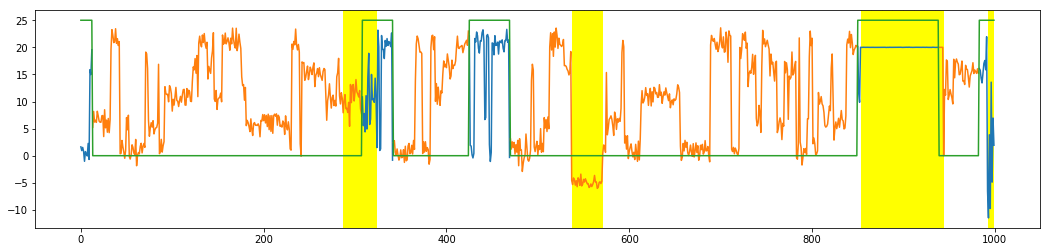

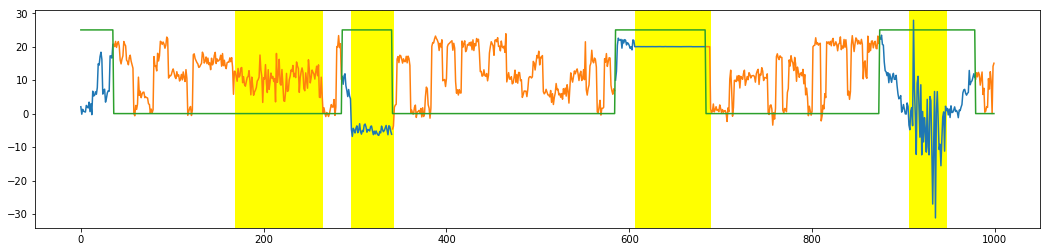

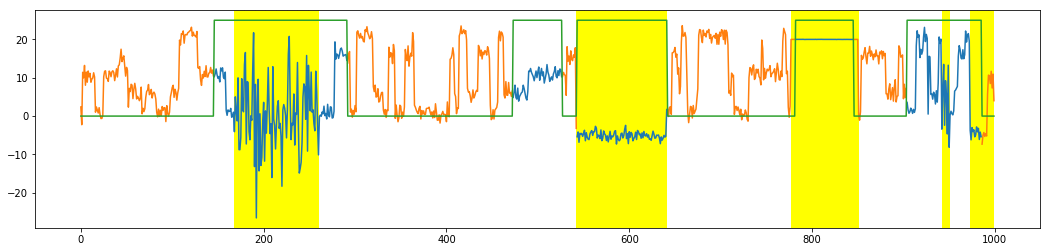

In [169]:
print_result(X_test[40:], Y_test[40:],c[40:], N=10)

In [174]:
Y_score, Y1_pred_score = score(Y_test, Y1_pred.reshape(len(Y_test), Y_test[0].shape[0]), ws = 50)   

In [175]:
report_ECDF = classification_report(np.concatenate(Y_test), Y1_pred, target_names=['normal', 'anomal'])
print(report_ECDF)

              precision    recall  f1-score   support

      normal       0.91      0.93      0.92     75522
      anomal       0.78      0.71      0.74     24478

    accuracy                           0.88    100000
   macro avg       0.84      0.82      0.83    100000
weighted avg       0.88      0.88      0.88    100000



In [140]:
report_ECDF = classification_report(np.concatenate(Y_score), np.concatenate(Y1_pred_score), target_names=['normal', 'anomal'])
print(report_ECDF)

              precision    recall  f1-score   support

      normal       0.73      0.81      0.77      1067
      anomal       0.76      0.65      0.70       933

    accuracy                           0.74      2000
   macro avg       0.74      0.73      0.74      2000
weighted avg       0.74      0.74      0.74      2000

